In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import scipy
import pandas as pd
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)
plt.rcParams['axes.formatter.use_mathtext'] = True

## Optuna

In [2]:
human = pd.read_pickle("data/carrabin.pkl")
b_n = pd.read_pickle("data/B_n_carrabin_mar6_dynamics.pkl")
rl_n = pd.read_pickle("data/RL_n_carrabin_mar6_dynamics.pkl")
rl_nl = pd.read_pickle("data/RL_nl_carrabin_mar6_dynamics.pkl")
nef_rl = pd.read_pickle("data/NEF_RL_carrabin_mar6_dynamics.pkl")
nef_wm = pd.read_pickle("data/NEF_WM_carrabin_mar6_dynamics.pkl")
combined = pd.concat([human, b_n, rl_n, rl_nl, nef_rl, nef_wm], ignore_index=True)

## Scipy

In [2]:
human = pd.read_pickle("data/carrabin.pkl")
bayes_n = pd.read_pickle("data/bayes_n_carrabin_feb12_dynamics.pkl")
rln = pd.read_pickle("data/RL_n2_carrabin_feb12_dynamics.pkl")
# nef_rl = pd.read_pickle("data/NEF_RL_carrabin_feb19_dynamics.pkl")
# nef_wm = pd.read_pickle("data/NEF_WM_carrabin_feb19_dynamics.pkl")
nef_rl = pd.read_pickle("data/NEF_RL_carrabin_feb21_dynamics.pkl")
nef_wm = pd.read_pickle("data/NEF_WM_carrabin_feb21_dynamics.pkl")
rlnl = pd.read_pickle("data/RL_nl_carrabin_feb21_dynamics.pkl")
rlne = pd.read_pickle("data/RL_ne_carrabin_feb21_dynamics.pkl")
dfs = [human, bayes_n, rln, nef_rl, nef_wm, rlnl, rlne]
combined = pd.concat(dfs, ignore_index=True)
combined['alpha'] = None

## Debug

In [13]:
human = pd.read_pickle("data/carrabin.pkl")
test = pd.read_pickle("data/RL_n_carrabin_1_dynamics.pkl")
combined = pd.concat([human, test], ignore_index=True)

# Calculate and plot

In [3]:
def add_alpha(combined):
    # human = pd.read_pickle("data/carrabin.pkl")
    combined['alpha'] = None
    for sid in combined['sid'].unique():
        print(sid)
        subdata = combined.query("sid==@sid")
        for i, row in subdata.iterrows():
            mt = row['type']
            sid = row['sid']
            trial = row['trial']
            stage = row['stage']
            response = np.clip(row['response'],-1,1)
            if stage>1:
                stage_old = stage - 1
                response_old = np.clip(subdata.query("type==@mt & trial==@trial & stage==@stage_old")['response'].to_numpy()[0],-1,1)
                delta = response_old - response
                combined.at[i, 'alpha'] = np.abs(delta)
                # color = human.query("sid==@sid & trial==@trial & stage==@stage")['color'].to_numpy()[0]
                # prediction_error = color - response_old
                # alpha = np.abs(delta / prediction_error) if prediction_error!=0 else 0
                # combined.at[i, 'alpha'] = alpha
    return combined

In [4]:
def plot_by_sids(combined):
    g = sns.FacetGrid(combined, col='sid', hue="type", sharey=False, legend_out=False) # sharex='row'
    g.map_dataframe(sns.kdeplot, x="alpha", clip=[0, 1], palette=palette[:5], fill=True, common_norm=False)
    g.add_legend()
    g.savefig("plots/alpha_distribution_vs_sid.jpg", dpi=100)
    plt.show()

In [5]:
def plot_by_stages(combined):
    g = sns.FacetGrid(combined, col="type", sharey='row', hue='stage', legend_out=False) # sharex='row'
    g.map_dataframe(sns.kdeplot, x="alpha", hue='stage', clip=[0, 1], palette=palette[:5], fill=True, common_norm=False, hue_order=[1,2,3,4,5])
    g.add_legend()
    g.savefig("plots/alpha_distribution_vs_stage.jpg", dpi=100)
    plt.show()

In [6]:
def plot_by_sids_and_stages(combined):
    g = sns.FacetGrid(combined, col="type", row="sid", sharey='row', hue='stage', legend_out=False) # sharex='row'
    g.map_dataframe(sns.kdeplot, x="alpha", hue='stage', clip=[0, 1], palette=palette[:5], fill=True, common_norm=False, hue_order=[1,2,3,4,5])
    g.add_legend()
    g.savefig("plots/alpha_distribution_vs_sid_and_stage.jpg", dpi=100)
    plt.show()

# Plot

In [7]:
combined = add_alpha(combined)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


/home/psipeter/observational-learning-social-networks/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot_args, **plot_kwargs)
/home/psipeter/observational-learning-social-networks/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot_args, **plot_kwargs)
/home/psipeter/observational-learning-social-networks/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot_args, **plot_kwargs)
/home/psipeter/observational-learning-social-networks/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot_args, **plot_kwargs)
/home/psipeter/observational-learning-social-networks/venv/lib/python3.11/site-packages/seaborn/axisgrid

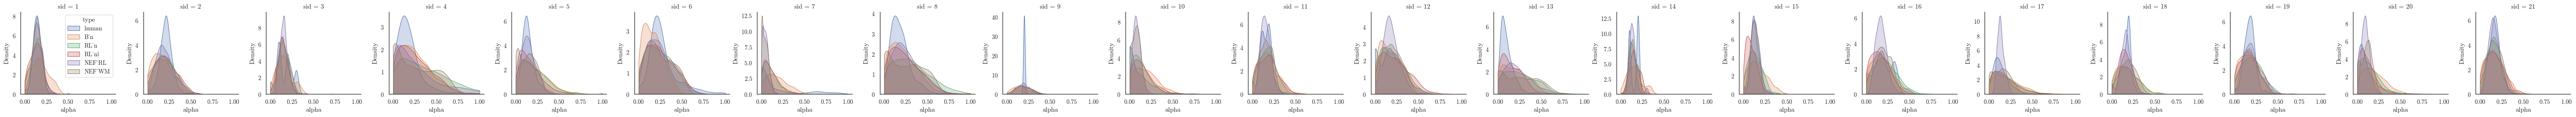

In [8]:
plot_by_sids(combined)

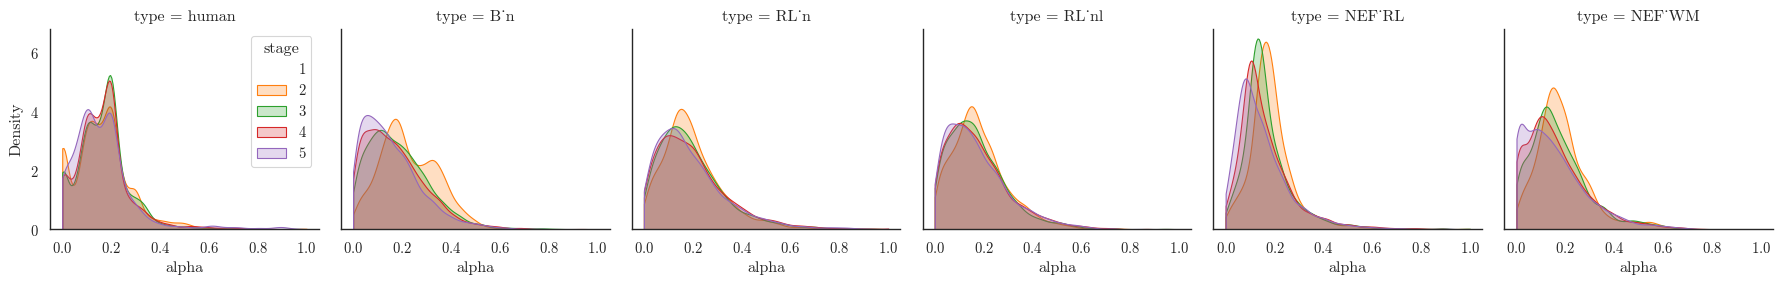

In [9]:
plot_by_stages(combined)

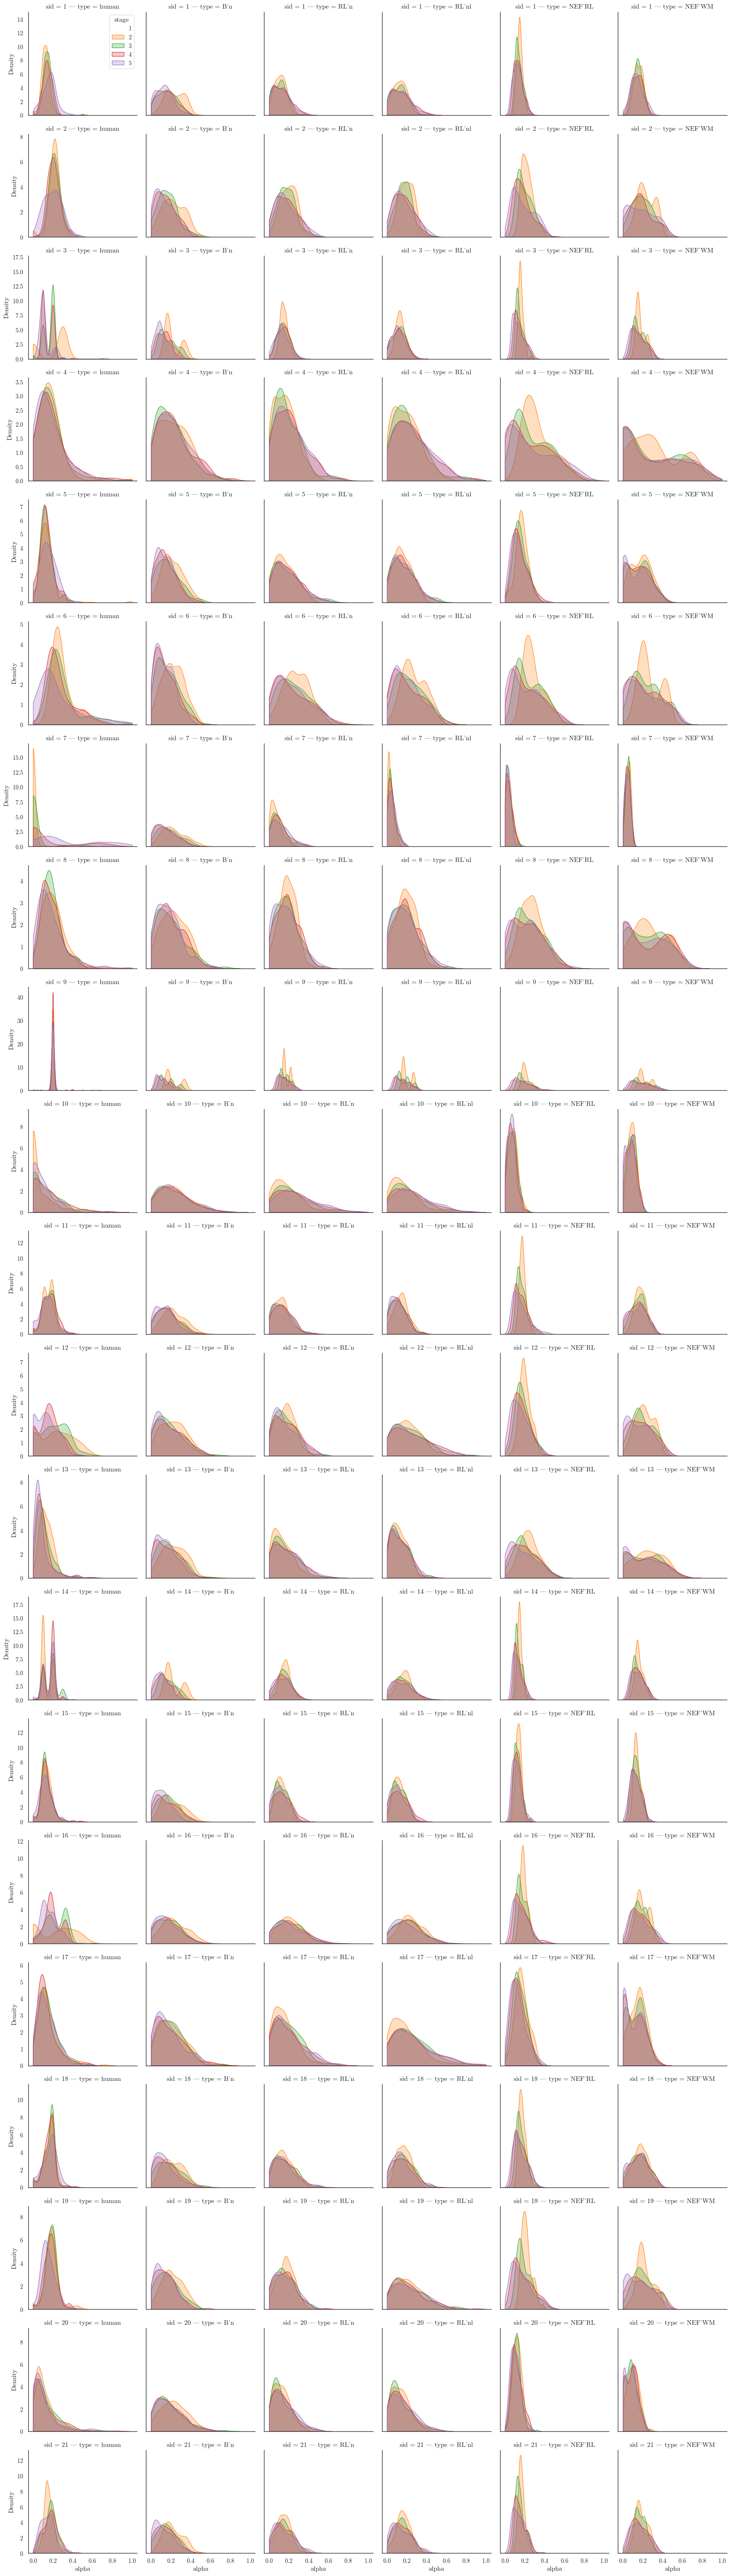

In [11]:
plot_by_sids_and_stages(combined)

# Change in expectation

In [2]:
from fit import get_expectations_carrabin

In [ ]:
lambdas = [0.0, 0.5, 1.0, 1.5]
sigmas = [0.05]
# sids = [1]
model_type = "RL_nl"
human = pd.read_pickle("data/carrabin.pkl")
sids = human['sid'].unique()
dfs = []
columns = ['type', 'sid', 'lambda', 'sigma', 'trial', 'stage', 'E', 'dE', 'dO', 'dA']
# human
print('human')
for sid in sids:
    for trial in human.query("sid==@sid")['trial'].unique():
        Eold_human = 0
        for stage in human.query("sid==@sid & trial==@trial")['stage'].unique():
            E_human = human.query("sid==@sid & trial==@trial & stage==@stage")['response'].to_numpy()[0]
            dE_human = np.abs(E_human-Eold_human)
            color = human.query("sid==@sid & trial==@trial & stage==@stage")['color'].to_numpy()[0]
            dO = np.abs(color - E_human)  # difference between response and most recent observation
            colors = human.query("sid==@sid & trial==@trial & stage<=@stage")['color'].to_numpy()
            average = np.mean(colors)  # difference between response and mean of all observations
            dA = np.abs(average - E_human)  # difference between response and mean of all observations
            if stage>1:
                dfs.append(pd.DataFrame([["human", sid, lambd, sigma, trial, stage, E_human, dE_human, dO, dA]], columns=columns))
            Eold_human = E_human

In [11]:
# model
for lambd in lambdas:
    for sigma in sigmas:
        print(f"lambda {lambd}, sigma {sigma}")
        params = [alpha, sigma, lambd]
        for sid in sids:
            alpha = pd.read_pickle(f"data/{model_type}_carrabin_mar6_params.pkl").query("sid==@sid")['alpha'].unique()[0]
            for trial in human.query("sid==@sid")['trial'].unique():
                Eold = 0
                for stage in human.query("sid==@sid & trial==@trial")['stage'].unique():
                    E = get_expectations_carrabin(model_type, params, sid, trial, stage, rng=np.random.RandomState(seed=trial))
                    dE = np.abs(E-Eold)
                    color = human.query("sid==@sid & trial==@trial & stage==@stage")['color'].to_numpy()[0]
                    dO = np.abs(color - E)  # difference between response and most recent observation
                    colors = human.query("sid==@sid & trial==@trial & stage<=@stage")['color'].to_numpy()
                    average = np.mean(colors)
                    dA = np.abs(average - E)  # difference between response and mean of all observations
                    if stage>1:
                        dfs.append(pd.DataFrame([[model_type, sid, lambd, sigma, trial, stage, E, dE, dO, dA]], columns=columns))
                    Eold = E
lambda_data = pd.concat(dfs, ignore_index=True)

lambda 0.0, sigma 0.05
lambda 0.5, sigma 0.05
lambda 1.0, sigma 0.05
lambda 1.5, sigma 0.05


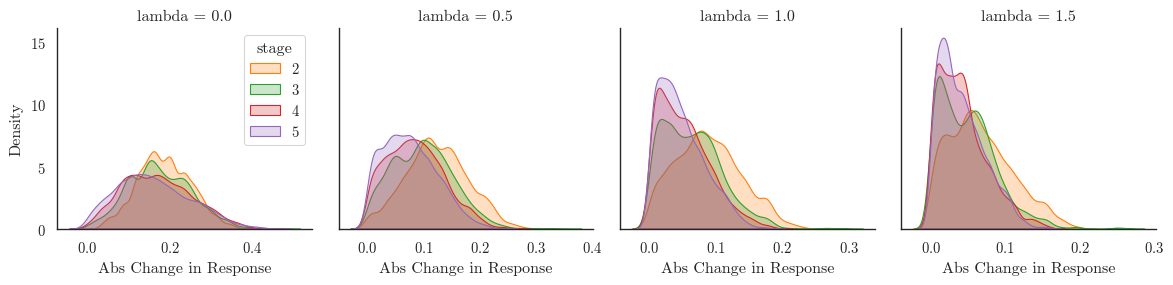

In [13]:
# g = sns.FacetGrid(lambda_data.query("type!='human'"), col="lambda", row='sigma', hue='stage', legend_out=False, sharey=True, sharex=False)
g = sns.FacetGrid(lambda_data.query("type!='human'"), col="lambda", hue='stage', legend_out=False, sharey=True, sharex=False)
# g = sns.FacetGrid(lambda_data, col="lambda", hue='stage', row='type', legend_out=False, sharey=True, sharex=False)
g.map_dataframe(sns.kdeplot, x="dE", hue='stage', palette=palette[:5], fill=True, common_norm=False, hue_order=[1,2,3,4,5])
g.add_legend()
g.set_axis_labels("Abs Change in Response")
# g.savefig("plots/lambda_demo.jpg", dpi=600)

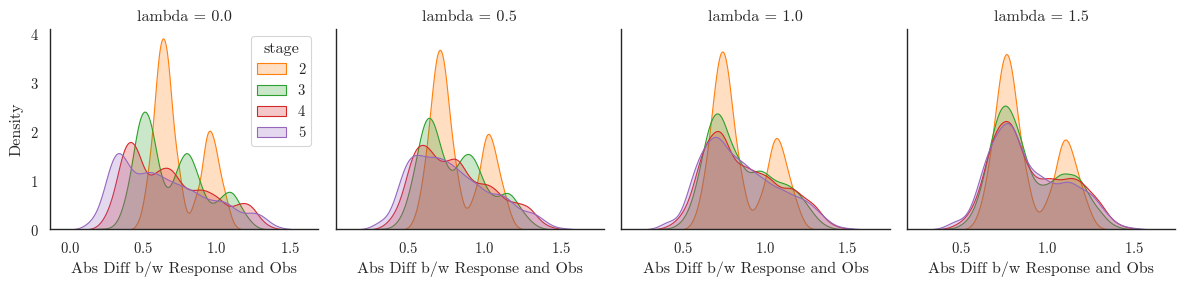

In [14]:
g = sns.FacetGrid(lambda_data.query("type!='human'"), col="lambda", hue='stage', legend_out=False, sharey=True, sharex=False)
g.map_dataframe(sns.kdeplot, x="dO", hue='stage', palette=palette[:5], fill=True, common_norm=False, hue_order=[1,2,3,4,5])
g.add_legend()
g.set_axis_labels("Abs Diff b/w Response and Obs")

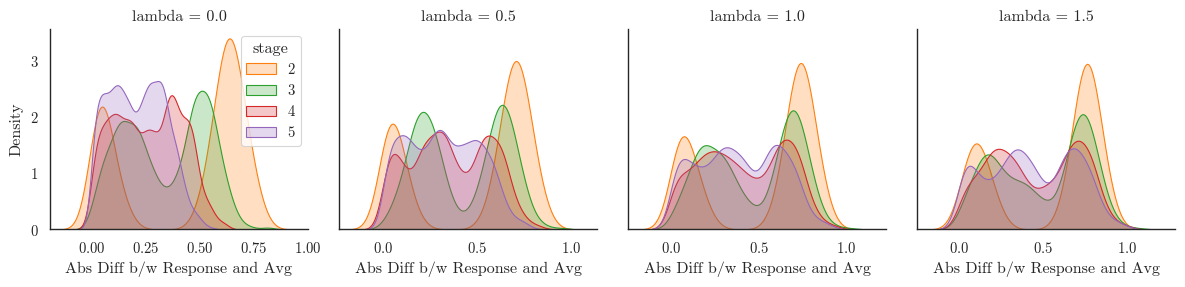

In [15]:
g = sns.FacetGrid(lambda_data.query("type!='human'"), col="lambda", hue='stage', legend_out=False, sharey=True, sharex=False)
g.map_dataframe(sns.kdeplot, x="dA", hue='stage', palette=palette[:5], fill=True, common_norm=False, hue_order=[1,2,3,4,5])
g.add_legend()
g.set_axis_labels("Abs Diff b/w Response and Avg")